In [7]:
%load_ext autoreload
%autoreload 2
from coc131_cw import COC131
import matplotlib.pyplot as plt
coc131 = COC131()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#load the data into variables coc131.x and coc131.y
coc131.q1()

Skipping complete data processing step


(array([0.]), '')

In [7]:
#testing with an input filename
coc131.q1(r"C:\Users\A\VSCodeRepos\dataset\EuroSAT_RGB\AnnualCrop\AnnualCrop_1.jpg")

Skipping complete data processing step


(array([149., 121., 120., ..., 106.,  94., 104.], shape=(3072,)), 'AnnualCrop')

In [3]:
scaler, standardised_data = coc131.q2(coc131.x)
print(scaler)
print(standardised_data.shape)

StandardScaler()
(27000, 3072)


## explain why i chose these params, parameter optimisation process

default: 
hyperparam = {
                        'hidden_layer_sizes': (100,),
                        'activation'       : 'relu',
                        'solver'           : 'adam',
                        'alpha'            : 1e-4,
                        'learning_rate_init': 1e-3,
                        'batch_size'       : 'auto',
                        'max_iter'         : 50
                        }

In [19]:
def plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparams):
    epochs = list(range(1, len(loss)+1))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Hyperparams: {hyperparams}")
    ax1.plot(epochs, loss, label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(epochs, train_acc, label='Training accuracy')
    ax2.plot(epochs, test_acc, label='Testing accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and testing accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:

        # 'alpha'              : [1e-4],
        # 'learning_rate_init': [1e-3],
        # 'batch_size': ['auto', 32],
        # 'activation'         : ['relu'],
        # 'momentum': [0.8],
        # 'solver'             : ['adam', 'sgd']

hyperparam = {
            'hidden_layer_sizes': (100,100),
            'solver'           : 'sgd',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 32,
            'momentum': 0.8,
            'max_iter'         : 50
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

MLPClassifier(batch_size=32, hidden_layer_sizes=(100, 100), max_iter=1,
              momentum=0.8, random_state=0, solver='sgd', warm_start=True)
[np.float64(1.4811143442982795), np.float64(1.174854277777087), np.float64(1.0586250321462678), np.float64(0.9748619238140878), np.float64(0.9092385849430655), np.float64(0.8518365368757179), np.float64(0.7997706323850434), np.float64(0.7519463473763314), np.float64(0.7109159741604887), np.float64(0.6704946919873328), np.float64(0.6332601824059011), np.float64(0.5995081232521745), np.float64(0.5691622478956181), np.float64(0.5378293441997163), np.float64(0.5109344727148689), np.float64(0.4861667209046562), np.float64(0.46109634686474243), np.float64(0.43726297868878133), np.float64(0.4173601518161885), np.float64(0.3973402488874155), np.float64(0.38076697667068016), np.float64(0.36476864639192563), np.float64(0.3485531215882849), np.float64(0.33632959268748497), np.float64(0.320487671125532), np.float64(0.308494525246948), np.float64(0.29400

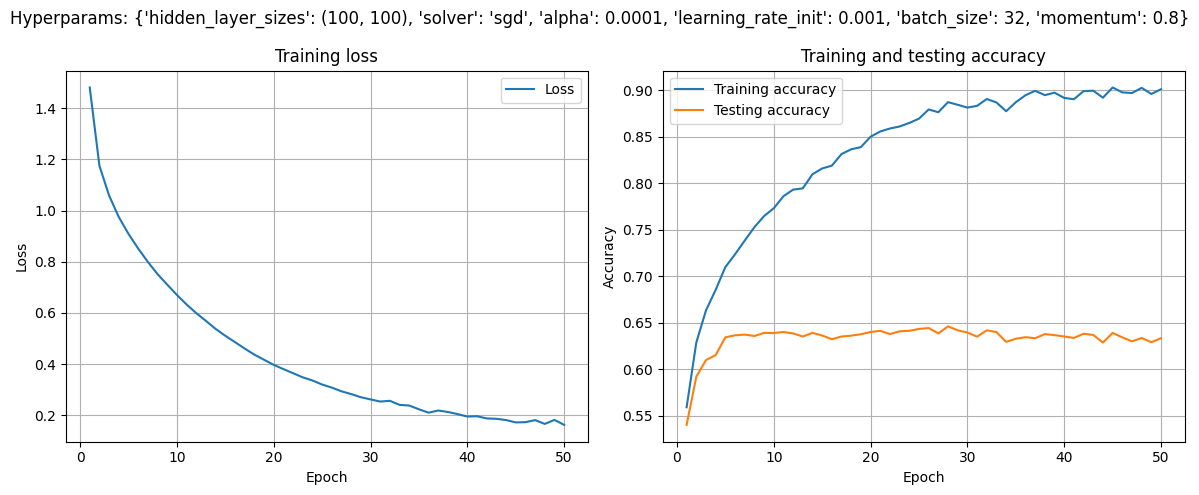

In [18]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

In [ ]:
hyperparam = {
            'hidden_layer_sizes': (100,100),
            'solver'           : 'adam',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 32,
            'max_iter'         : 25
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

In [ ]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

In [12]:

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [ ]:
param_grid = {
        'hidden_layer_sizes': [
        (50,), (100,), (100, 50)],
        'alpha'              : [1e-4],
        'learning_rate_init': [1e-3],
        'batch_size': ['auto', 32],
        'activation'         : ['relu'],
        'momentum': [0.8],
        'solver'             : ['adam', 'sgd']
    }

base_clf = MLPClassifier(random_state=0, max_iter=200)

grid = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2
)
grid.fit(standardised_data, coc131.y)
best_params = grid.best_params_
print(best_params)
score = grid.best_score_
print(score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#### plan:
get best params from grid search  
do 4-5 runs of params leading up to grid search - then visualise each run, as well as a final comparison  
run q4 on the best params found to learn alpha  
q5  
q6  